In [68]:
%matplotlib inline

In [69]:
import os
from google.cloud import bigquery
import bq_helper
import numpy_stats

In [70]:
os.environ['GOOGLE_CRED_DIR']=os.path.join(os.environ['HOME'],'creds')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=os.path.join(os.environ['GOOGLE_CRED_DIR'],'apt-footing-235018-aeb185ac9e31.json')

In [72]:
github_repos = bq_helper.BigQueryHelper(active_project= "bigquery-public-data", 
                                       dataset_name = "github_repos")

In [73]:
github_repos.list_tables()

['commits',
 'contents',
 'files',
 'languages',
 'licenses',
 'sample_commits',
 'sample_contents',
 'sample_files',
 'sample_repos']

In [75]:
api_results = bq_helper.BigQueryHelper(active_project= "apt-footing-235018", 
                                       dataset_name = "NumpyAPI")
api_results.list_tables()

['content',
 'files',
 'functions',
 'imports',
 'methods',
 'projects',
 'results',
 'results2',
 'sample_results',
 'watched',
 'watched_python',
 'watched_sample_files']

In [76]:
github_repos.table_schema('files')

,name,type,mode,description
0,repo_name,STRING,NULLABLE,None
1,ref,STRING,NULLABLE,None
2,path,STRING,NULLABLE,None
3,mode,INTEGER,NULLABLE,None
4,id,STRING,NULLABLE,None
5,symlink_target,STRING,NULLABLE,None


Query Constructed for API functions..  

In [82]:

from numpy_stats import *
funs = funs[:3] # print Query for first few API functions only

query = build_countAPIs(funlist=funs,api_table=
                        nest_table(
                            build_numpyAPI_query(
                                funlist=funs,content_table = nest_table(
                                    build_py_content(content_table_name='[bigquery-public-data:github_repos.contents]',
                                                     join=join_py(file_table = '[bigquery-public-data:github_repos.files]'))
                                ))))
print(query)

SELECT
count(CASE WHEN numpy_abs THEN 1 END) AS numpy_abs_count,
count(CASE WHEN numpy_absolute THEN 1 END) AS numpy_absolute_count,
count(CASE WHEN numpy_absolute_import THEN 1 END) AS numpy_absolute_import_count
FROM (SELECT
REGEXP_MATCH( c.content,r'(np\.|numpy\.)abs\(\s?[A-Za-z0-9_.\(\)]*\s?\)') AS numpy_abs,
REGEXP_MATCH( c.content,r'(np\.|numpy\.)absolute\(\s?[A-Za-z0-9_.\(\)]*\s?\)') AS numpy_absolute,
REGEXP_MATCH( c.content,r'(np\.|numpy\.)absolute_import\(\s?[A-Za-z0-9_.\(\)]*\s?\)') AS numpy_absolute_import
FROM (SELECT
*
FROM
[bigquery-public-data:github_repos.contents] AS c
INNER JOIN
(SELECT
*
FROM
[bigquery-public-data:github_repos.files] AS f
WHERE
(
f.path LIKE '%.py' 
OR
f.path LIKE '%.ipynb'
) ) AS p
ON
c.id = p.id))


### AFter copying and pasting the above query into BigQuery and saving as sample_results... 

In [ ]:
#Pull data from bigQuery
#r = api_results.query_to_pandas_safe('SELECT * FROM `apt-footing-235018.NumpyAPI.sample_results`')
#r

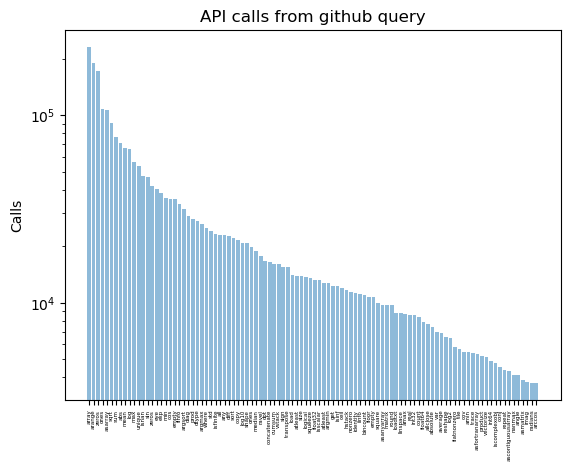

In [91]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
import pandas as pd
r = pd.read_csv('full_results2.csv').T

r2 = r.loc[r[0]>0].sort_values(0,ascending=False)
r2.index = [ f.split('_')[1] for f in list(r2.index)]


r2 = r2[:100]
y_pos = np.arange(len(r2))
calls = r2[0]
 
fig1 = plt.bar(y_pos, calls, align='center', alpha=0.5,log=True)
plt.xticks(y_pos,r2.index,rotation='vertical',fontsize=4)
plt.ylabel('Calls')
plt.title('API calls from github query')

fig1 = plt.gcf() 
plt.show()
fig1.savefig('results.svg')
fig1.savefig('results.png', dpi=500)

In [92]:
sum(r[0] == 0)

84

#### Undetected functions are as follows...  some of these appear to be constants which were undetected due to '\(' regex, and will be added in the next iteration.


In [133]:
undetected_names = [ '_'.join(l.split('_')[1:-1])  for l in list(r.loc[r[0]==0].index)]
for row in np.arange(len(undetected_names)%5):
    print(*undetected_names[row:row+5],sep=', ')

absolute_import, add_docstring, add_newdoc, add_newdoc_ufunc, add_newdocs
add_docstring, add_newdoc, add_newdoc_ufunc, add_newdocs, apply_over_axes
add_newdoc, add_newdoc_ufunc, add_newdocs, apply_over_axes, bench
add_newdoc_ufunc, add_newdocs, apply_over_axes, bench, busdaycalendar


In [109]:
api = [(x, type(np.__getattribute__(x))) for x in dir(np) if not x.startswith('__')]
ufuncs = [x for x in api if x[1] is np.ufunc]
builtins = [x for x in api if x[1] is type(np.zeros)]
functions = [x for x in api if x[1] is type(lambda x: x)]
api_things = list(set(x[1] for x in api))
api_grouped = {y:[x[0] for x in api if x[1] is y] for y in api_things}

In [126]:
api_grouped.keys()

dict_keys([<class 'numpy.core.numerictypes._typedict'>, <class 'numpy._globals._NoValueType'>, <class 'module'>, <class 'numpy.lib.index_tricks.RClass'>, <class 'numpy.ufunc'>, <class 'numpy.lib.index_tricks.nd_grid'>, <class 'numpy.lib.index_tricks.IndexExpression'>, <class '__future__._Feature'>, <class 'function'>, <class 'builtin_function_or_method'>, <class 'int'>, <class 'numpy.bool_'>, <class 'numpy.lib.index_tricks.CClass'>, <class 'numpy.testing._private.pytesttester.PytestTester'>, <class 'bool'>, <class 'dict'>, <class 'tuple'>, <class 'type'>, <class 'str'>, <class 'float'>, <class 'NoneType'>])

In [135]:
 if 'benchundetected_names.remove('bench')

In [137]:
udetected_grouped = { type(np.__getattribute__(x)): x for x in undetected_names } 

In [138]:
undetected_grouped

{numpy.core.numerictypes._typedict: ['cast', 'nbytes'],
 numpy._globals._NoValueType: ['_NoValue'],
 module: ['_distributor_init',
  '_globals',
  '_import_tools',
  '_mat',
  '_mklinit',
  'add_newdocs',
  'char',
  'compat',
  'core',
  'ctypeslib',
  'emath',
  'fft',
  'lib',
  'linalg',
  'ma',
  'math',
  'matrixlib',
  'polynomial',
  'random',
  'rec',
  'sys',
  'testing',
  'version',
  'warnings'],
 numpy.lib.index_tricks.RClass: ['r_'],
 numpy.ufunc: ['abs',
  'absolute',
  'add',
  'arccos',
  'arccosh',
  'arcsin',
  'arcsinh',
  'arctan',
  'arctan2',
  'arctanh',
  'bitwise_and',
  'bitwise_not',
  'bitwise_or',
  'bitwise_xor',
  'cbrt',
  'ceil',
  'conj',
  'conjugate',
  'copysign',
  'cos',
  'cosh',
  'deg2rad',
  'degrees',
  'divide',
  'divmod',
  'equal',
  'erf',
  'exp',
  'exp2',
  'expm1',
  'fabs',
  'float_power',
  'floor',
  'floor_divide',
  'fmax',
  'fmin',
  'fmod',
  'frexp',
  'gcd',
  'greater',
  'greater_equal',
  'heaviside',
  'hypot',
  'in